In [9]:
from nilearn import datasets
#dir='/raid/nilearn_data'
adhd_dataset = datasets.fetch_adhd(n_subjects=3)
func_filenames = adhd_dataset.func  # list of 4D nifti files for each subject

# print basic information on the dataset
print('First functional nifti image (4D) is at: %s' %
      func_filenames[0])  # 4D data

from nilearn.decomposition import CanICA

canica = CanICA(smoothing_fwhm=6.,
                memory="nilearn_cache", memory_level=2,
                threshold=3., verbose=10, random_state=0)
x_train=canica.prepare_data(func_filenames)


First functional nifti image (4D) is at: /home/uga_qinglin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
[MultiNiftiMasker.fit] Loading data from [/home/uga_qinglin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz, /home/uga_qinglin/nilearn_data/adhd/data/0010064/0010064_rest_tshift_RPI_voreg_mni.nii.gz, /home/uga_qinglin
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data
/home/uga_qinglin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
/home/uga_qinglin/nilearn_data/adhd/data/0010064/0010064_rest_tshift_RPI_voreg_mni.nii.gz
/home/uga_qinglin/nilearn_data/adhd/data/0010128/0010128_rest_tshift_RPI_voreg_mni.nii.gz


In [10]:
original_dim=x_train.shape[1]

In [11]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(original_dim,))
# "encoded" is the encoded representation of the input
encoded = Dense(128, activation='tanh',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
encoded = Dense(64, activation='tanh',
                activity_regularizer=regularizers.l1(10e-5))(encoded)
encoded = Dense(32, activation='tanh',
                activity_regularizer=regularizers.l1(10e-5))(encoded)

decoded = Dense(64, activation='tanh')(encoded)
decoded = Dense(128, activation='tanh')(decoded)
decoded = Dense(original_dim, activation='tanh')(decoded)


# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
#encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
# create the decoder model
#decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=100,
                shuffle=True)

Using TensorFlow backend.


Epoch 1/50
60/60 [==============================] - 4s 73ms/step - loss: 3.3940
Epoch 2/50
60/60 [==============================] - 0s 2ms/step - loss: 3.3792
Epoch 3/50
60/60 [==============================] - 0s 2ms/step - loss: 2.9344
Epoch 4/50
60/60 [==============================] - 0s 2ms/step - loss: 2.5503
Epoch 5/50
60/60 [==============================] - 0s 2ms/step - loss: 2.2086
Epoch 6/50
60/60 [==============================] - 0s 2ms/step - loss: 1.9462
Epoch 7/50
60/60 [==============================] - 0s 2ms/step - loss: 1.7279
Epoch 8/50
60/60 [==============================] - 0s 2ms/step - loss: 1.5549
Epoch 9/50
60/60 [==============================] - 0s 2ms/step - loss: 1.3819
Epoch 10/50
60/60 [==============================] - 0s 2ms/step - loss: 1.2387
Epoch 11/50
60/60 [==============================] - 0s 1ms/step - loss: 1.1053
Epoch 12/50
60/60 [==============================] - 0s 2ms/step - loss: 0.9514
Epoch 13/50
60/60 [=============================

In [14]:
y=encoder.predict(x_train)


In [16]:
%matplotlib inline
import numpy as np
t = range(0, 200)

import matplotlib.pyplot as plt
plt.plot(t, y[:,1])

In [17]:
from sklearn.linear_model import Lasso
clf = Lasso(alpha=0.1)
clf.fit(y,x_train)
print(clf.coef_.shape)

(63043, 32)


In [18]:
#W=decoder_mean.get_weights()
#components_img=W[0]


In [19]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=canica.masker_.mask_img_, standardize=True)
masker.fit()

import numpy as np
components_img=np.transpose(clf.coef_)
components_img=canica.thresholding(components_img)
components_img = masker.inverse_transform(components_img)

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')
/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


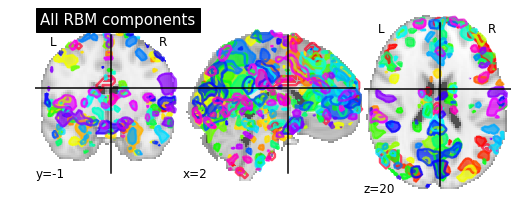

In [20]:
from nilearn import plotting

plotting.plot_prob_atlas(components_img, view_type='filled_contours',
                         title='All RBM components')

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


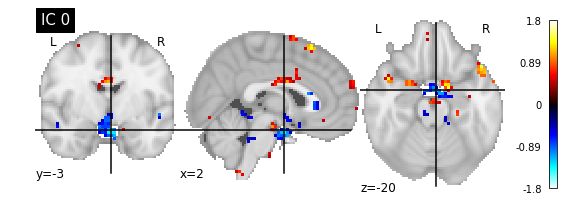

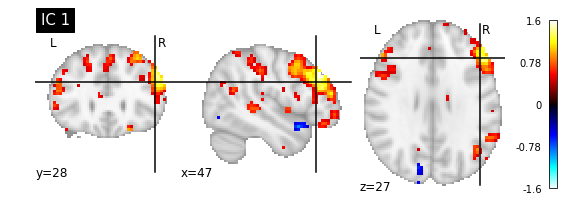

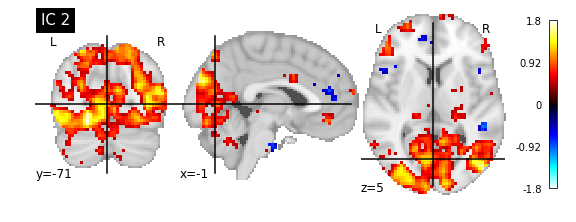

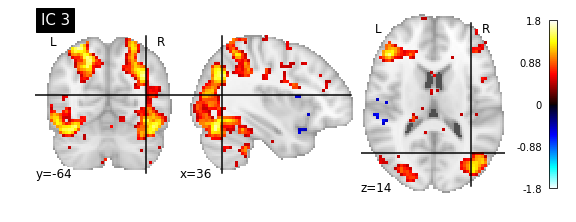

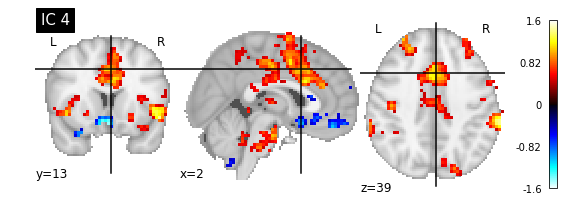

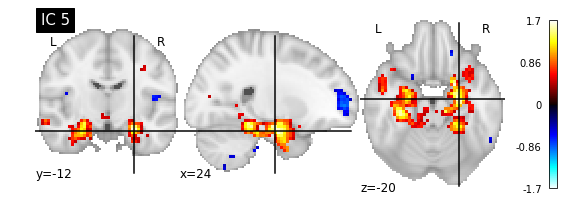

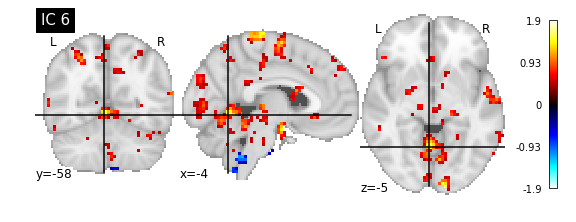

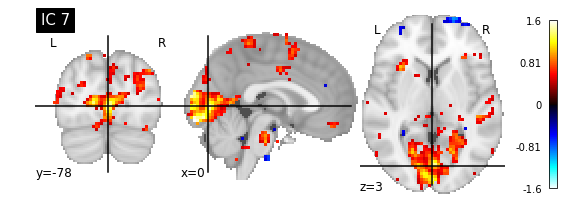

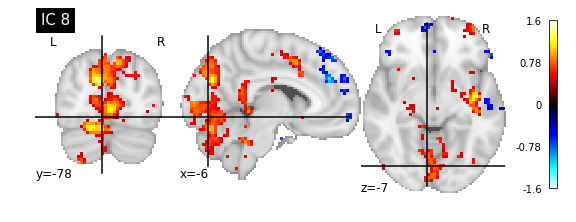

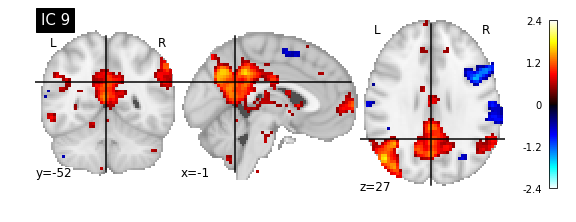

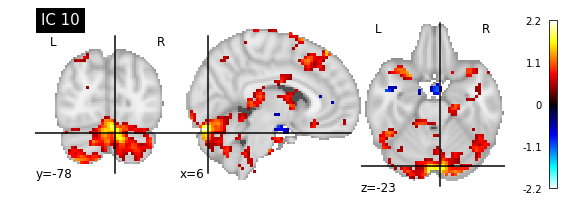

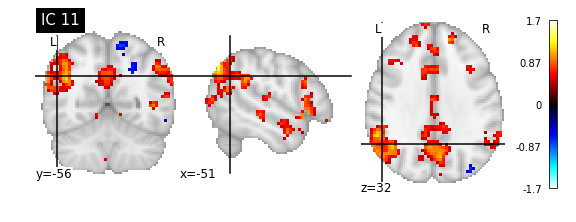

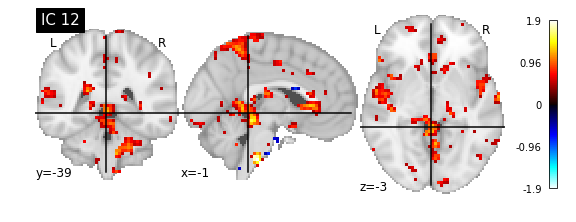

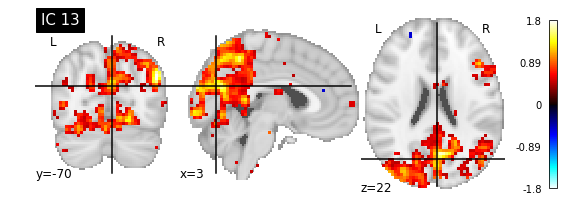

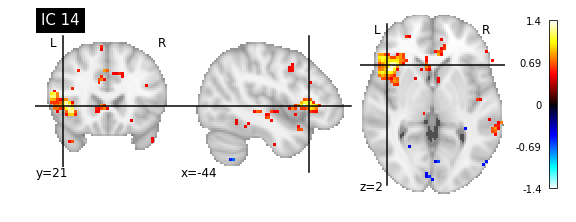

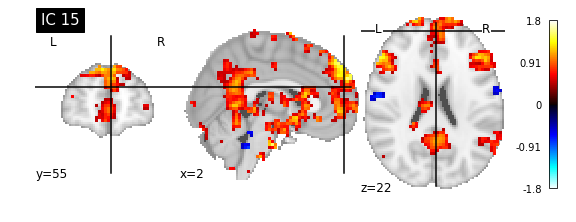

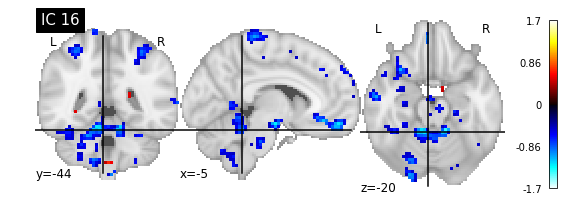

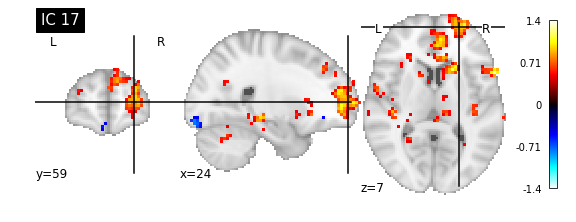

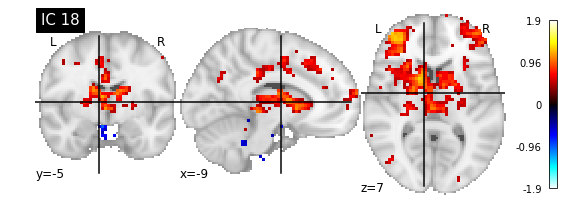

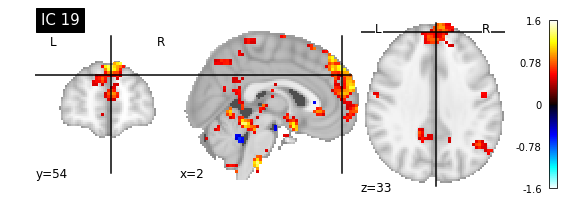

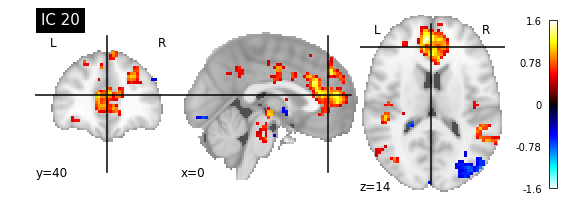

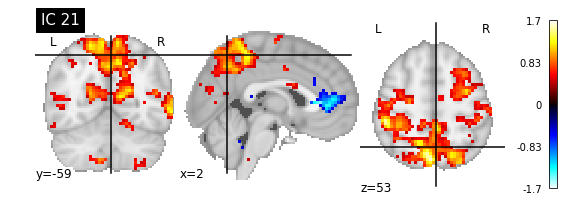

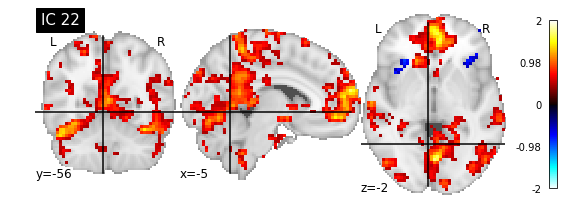

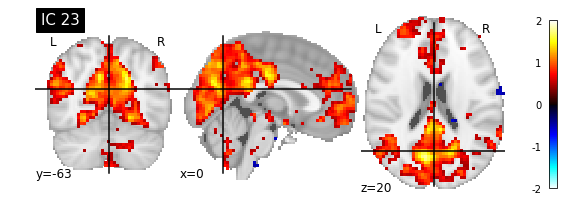

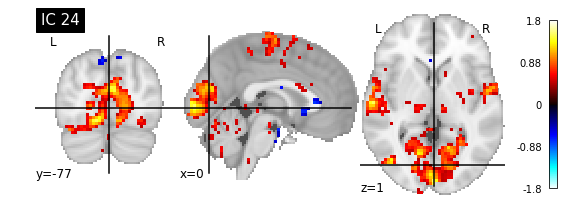

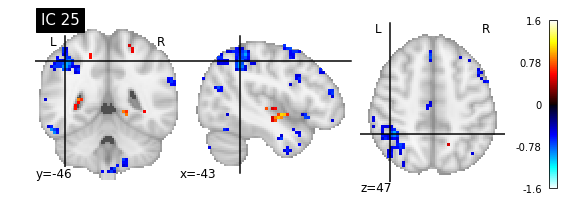

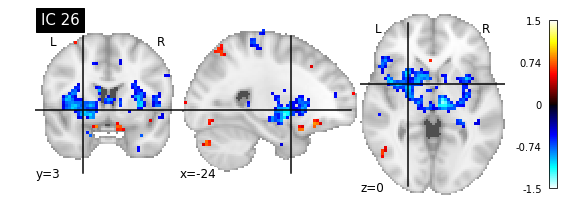

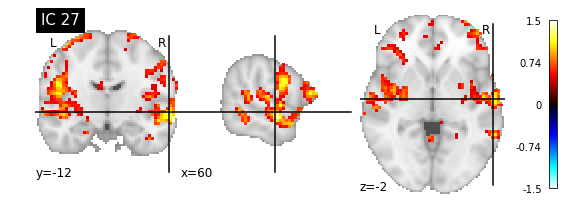

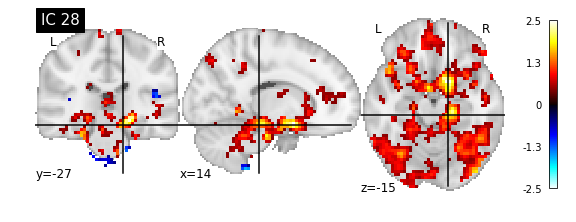

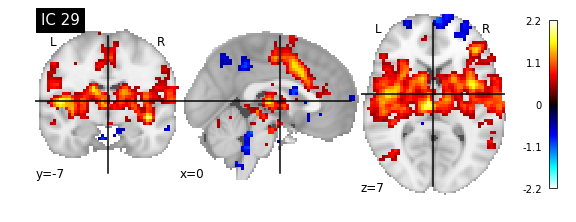

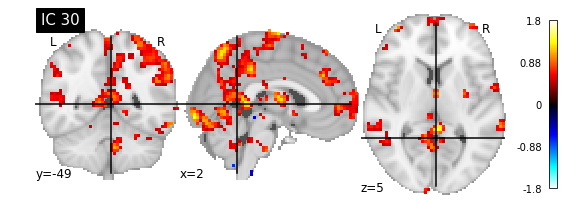

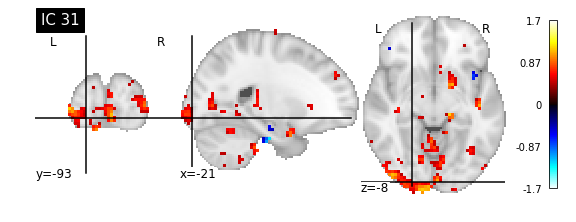

In [21]:
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="ortho", title="IC %d" % i,
                  cut_coords=None, colorbar='bwr')

show()